<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/U_net%2C_VGG_type_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2020/04/28 考虑不同的U-net， VGG type类型。  \\
2020/05/10 用不同size的input shape  \\
2020/05/17 用Fashion mnist测试一下。 \\
2020/05/21 用random image测试。  \\
2020/08/12 收到reviewer评论，用batch_normalization测试一下U-net

Import python package

In [78]:
from keras.layers import Input, Dense , Dropout
from keras.models import Model
import matplotlib.pyplot as plt
import pickle
import numpy as np 
from keras.layers import concatenate

In [79]:
cd /content/drive/My Drive/Colab Notebooks/MMF data/24hours_Mix_datasets/24hours_img_v2

/content/drive/My Drive/Colab Notebooks/MMF data/24hours_Mix_datasets/24hours_img_v2


In [80]:
## The dataset main_24hours_v2_80000_run2.dat is for 28x28 input, to run this dataset, you probably need to adjust the neural network architecture a little bit (i.e. the input and output size.)

# with open('main_24hours_v2_80000_run2.dat','rb') as f:
#   imgs_all = pickle.load(f)


#  main_24hours_v2_80000_run2_64px.dat is not available in github now due to its large size
#  However, the dataset is openly available in DR-NTU dataset base.  The website is https://researchdata.ntu.edu.sg/dataset.xhtml?persistentId=doi:10.21979/N9/SUTZX9
#  You can download the file	'Dat_scrambled_Ba.dat	' and rename it as 'main_24hours_v2_80000_run2_64px.dat' to run the following code.


with open('main_24hours_v2_80000_run2_64px.dat','rb') as f:
  imgs_all = pickle.load(f)

with open('main_24hours_v2_80000_run2_SLM.dat','rb') as f:
  origins_all = pickle.load(f)

with open('main_24hours_v2_80000_run2_Records.dat','rb') as f:
  records = pickle.load(f)



data preprocessing

In [81]:
#convert records file into a array
N = [0]
for i in records:
  if i == 'Start point' or i == 'end point':
    pass
  else:
    N.append(records[i])



mnist_imgs = []
mnist_origins = []

#选取其中的mnist图片，如果要选择fashion_mnist，那么改为 i%2 == 0即可。
#N_12, N_15代表选取的是12 - 15 hours的图片。
for i in range(N[0], N[10]):
  if i % 2 == 1:
    mnist_imgs.append(imgs_all[i])
    mnist_origins.append(origins_all[i])



N_input = len(mnist_imgs)
N_train = int(0.8* N_input)
N_test = N_input - N_train
print('共有{}张图片，其中{}张为训练图片，{}张为测试图片'.format(N_input, N_train, N_test))

共有16186张图片，其中12948张为训练图片，3238张为测试图片


In [82]:
imgs = np.array(mnist_imgs).astype(float)   
origins = np.array(mnist_origins).astype(float)

def next_batch(batch_size, data_input, data_output):
    '''
    Return a total of `batch_size` random samples 
    '''
    idx = np.arange(0 , len(data_input))
    np.random.shuffle(idx)
    idx = idx[:batch_size]
    data_shuffle_input = [data_input[ i] for i in idx]
    data_shuffle_output = [data_output[ i] for i in idx]
    return np.asarray(data_shuffle_input) , np.asarray(data_shuffle_output)


# shuffle input datasets
imgs, origins = next_batch(N_input,imgs, origins)

train_imgs = imgs[0:N_train].reshape(-1,64,64,1)
train_origins = origins[0:N_train].reshape(-1,28,28,1)
test_imgs = imgs[N_train:N_input].reshape(-1,64,64,1)
test_origins = origins[N_train:N_input].reshape(-1,28,28,1)


# Train with 28x28 input images

# train_imgs = imgs[0:N_train].reshape(-1,28,28,1)
# train_origins = origins[0:N_train].reshape(-1,28,28,1)
# test_imgs = imgs[N_train:N_input].reshape(-1,28,28,1)
# test_origins = origins[N_train:N_input].reshape(-1,28,28,1)

for i in range(N_train):
  train_imgs[i] = train_imgs[i]/256.0
  train_origins[i] = train_origins[i]/256.0

for i in range(N_test):
  test_imgs[i] = test_imgs[i]/256.0
  test_origins[i] = test_origins[i]/256.0

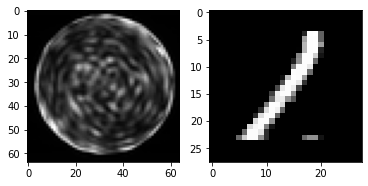

In [83]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_imgs[0].reshape(64,64), cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(train_origins[0].reshape(28,28), cmap = 'gray')
plt.show()

Set up Neural network

In [84]:
from keras.layers import Input,  Conv2D, MaxPooling2D, UpSampling2D , Flatten , Reshape , Dense ,Dropout , Activation
from keras.models import Model ,Sequential
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.activations import sigmoid

In [85]:
 # adapt this if using `channels_first` image data format

In [86]:
Neural_network = 4
# 0 for Dense
# 1 for Autoencoder 
# 2 for VGG-CNN
# 6 for reverse VGG-CNN
# 3 for U-net
# 4 for U-net optimization
# 7 for U-net 28x28 input



## 0 is the dense neural network used in paper
## 4 is the U-net neural network used in paper
## 2 is the VGG neural network used in paper

In [87]:
# Dense 

if Neural_network == 0:
  input_img = Input(shape=(64, 64, 1)) 

  x = Flatten()(input_img)
  x = Dense(1024)(x)
  #x = BatchNormalization()(x)
  x = Activation('sigmoid')(x)
  x = Dropout(0.2)(x)
  x = Dense(784, activation='sigmoid')(x)
  output = Reshape((28,28,1))(x)

  autoencoder = Model(input_img, output)

In [88]:
 # Real U-net

# if Neural_network == 3:
#   inputs = Input(shape=(28, 28, 1))
#   conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#   pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#   conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#   pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#   conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#   pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#   up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool3))
#   merge8 = concatenate([conv2,up8], axis = 3)
#   conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#   conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#   up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#   merge9 = concatenate([conv1,up9], axis = 3)
#   conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#   conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

#   conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#   autoencoder = Model(input = inputs, output = conv10)
  

In [89]:
# Autoencoder

if Neural_network == 1:

  input_img = Input(shape=(64, 64, 1)) 

  a = 1

  x = Conv2D(int(32*a), (3, 3), activation='relu', padding='same')(input_img)
  x = Dropout(0.1)(x)
  x = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same')(x)
  x = Dropout(0.1)(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  
  x = Conv2D(int(128*a), (3, 3), activation='relu', padding='same')(x)
  x = Dropout(0.2)(x)
  x = MaxPooling2D((2, 2), padding='same')(x)

  x = Flatten()(x)
  encoded = Dense(512)(x)

  latent_space = Dense(4*4*32)(encoded)
  latent_space = Dropout(0.3)(latent_space)
  latent_space = Reshape((4,4,32))(latent_space)

  x = Conv2D(int(128*a), (3, 3), activation='relu', padding='same')(latent_space)
  x = Dropout(0.2)(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same')(x)
  x = Dropout(0.1)(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(int(32*a), (3, 3), activation='relu')(x)
  x = Dropout(0.1)(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


  autoencoder = Model(input_img, decoded)

In [90]:
# with concatenate structure 

if Neural_network == 3:
  
  input_img = Input(shape=(64, 64, 1)) 

  a = 1 # a = 0.5, 1.0, 1.5

  x = Conv2D(int(16*a), (3, 3),activation='relu', padding='same',kernel_initializer = 'he_normal')(input_img)

  x = MaxPooling2D((2, 2), padding='same')(x)   # 32x32
  x1 = Conv2D(int(32*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x) 
  x2 = Conv2D(int(32*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x1) 

  x3 = MaxPooling2D((2, 2), padding='same')(x2)   #16x16
  x4 = Conv2D(int(64*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x3)
  x4 = Conv2D(int(64*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x4) 
  x5 = Dropout(0.2)(x4)

  x6 = MaxPooling2D((2, 2), padding='same')(x5)   # 8x8
  x7 = Conv2D(int(128*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x6) 
  x7 = Conv2D(int(128*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x7)   
  x8 = Dropout(0.2)(x7)

  x9 = MaxPooling2D((2, 2), padding='same')(x8)   # 4x4
  x10 = Conv2D(int(256*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x9)
  x10 = Conv2D(int(256*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x10)
  x10 = Dropout(0.2)(x10)

  x = Conv2D(int(128*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x10)) #8x8
  merge1 = concatenate([x7,x], axis = 3)
  x = Conv2D(int(128*a), 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(merge1)
  x = Conv2D(int(128*a), 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(x)  

  x = Conv2D(int(64*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x)) # 16x16
  merge2 = concatenate([x4,x], axis = 3)
  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge2)
  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(x)

  x = Conv2D(int(32*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x)) #32x32
  merge3 = concatenate([x1,x], axis = 3)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge3)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(x)

  x = Conv2D(int(32*a), (5, 5), activation='sigmoid', padding='valid')(merge3)  #28x28
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)



In [91]:
# U-net 28x28 inputs

if Neural_network == 7:
  
  input_img = Input(shape=(28, 28, 1)) 

  a = 1 # a = 0.5, 1.0, 1.5

  x = Conv2D(int(16*a), (3, 3),activation='relu', padding='same',kernel_initializer = 'he_normal')(input_img)  #28x28

  x1 = Conv2D(int(32*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x) 
  x2 = Conv2D(int(32*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x1) 

  x3 = MaxPooling2D((2, 2), padding='same')(x2)   #14x14
  x4 = Conv2D(int(64*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x3)
  x4 = Conv2D(int(64*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x4) 
  x5 = Dropout(0.2)(x4)

  x6 = MaxPooling2D((2, 2), padding='same')(x5)   # 7x7
  x7 = Conv2D(int(128*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x6) 
  x7 = Conv2D(int(128*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x7)   
  x8 = Dropout(0.2)(x7)

  x9 = MaxPooling2D((2, 2), padding='same')(x8)   # 4x4
  x10 = Conv2D(int(256*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x9)
  x10 = Conv2D(int(256*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x10)
  x10 = Dropout(0.2)(x10)

  x = Conv2D(int(128*a), 2, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x10)) #7x7
  merge1 = concatenate([x7,x], axis = 3)
  x = Conv2D(int(128*a), 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(merge1)
  x = Conv2D(int(128*a), 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(x)  

  x = Conv2D(int(64*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x)) # 14x14
  merge2 = concatenate([x4,x], axis = 3)
  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge2)
  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(x)

  x = Conv2D(int(32*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x)) #28x28
  merge3 = concatenate([x1,x], axis = 3)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge3)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(x)

  x = Conv2D(int(32*a), (3, 3), activation='sigmoid', padding='same')(merge3)  #28x28
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)


In [92]:
# Optimization with concatenate structure 

if Neural_network == 4:
  
  input_img = Input(shape=(64, 64, 1)) 

  a = 4 # a = 0.5, 1.0, 1.5

  x = Conv2D(int(16*a), (3, 3), padding='same',kernel_initializer = 'he_normal')(input_img)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D((2, 2), padding='same')(x)   # 32x32
  x1 = Conv2D(int(32*a), (3, 3), padding='same',kernel_initializer = 'he_normal')(x) 
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x2 = Conv2D(int(32*a), (3, 3), padding='same',kernel_initializer = 'he_normal')(x1) 
  x2 = BatchNormalization()(x2)
  x2 = Activation('relu')(x2)


  x3 = MaxPooling2D((2, 2), padding='same')(x2)   #16x16
  x4 = Conv2D(int(64*a), (3, 3),  padding='same',kernel_initializer = 'he_normal')(x3)
  x4 = BatchNormalization()(x4)
  x4 = Activation('relu')(x4)
  x5 = Conv2D(int(64*a), (3, 3), padding='same',kernel_initializer = 'he_normal')(x4)
  x5 = BatchNormalization()(x5)
  x5 = Activation('relu')(x5) 
  #x5 = Dropout(0.2)(x5)


  x6 = MaxPooling2D((2, 2), padding='same')(x5)   # 8x8
  x7 = Conv2D(int(128*a), (3, 3),  padding='same',kernel_initializer = 'he_normal')(x6)
  x7 = BatchNormalization()(x7)
  x7 = Activation('relu')(x7) 
  x8 = Conv2D(int(128*a), (3, 3),  padding='same',kernel_initializer = 'he_normal')(x7) 
  x8 = BatchNormalization()(x8)
  x8 = Activation('relu')(x8)  
  #x8 = Dropout(0.2)(x8)

  x9 = MaxPooling2D((2, 2), padding='same')(x8)   # 4x4
  x10 = Conv2D(int(256*a), (3, 3), padding='same',kernel_initializer = 'he_normal')(x9)
  x10 = BatchNormalization()(x10)
  x10 = Activation('relu')(x10)
  x10 = Conv2D(int(256*a), (3, 3), padding='same',kernel_initializer = 'he_normal')(x10)
  x10 = BatchNormalization()(x10)
  x10 = Activation('relu')(x10)
  #x10 = Dropout(0.2)(x10)

  x = Conv2D(int(128*a), 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x10)) #8x8
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  merge1 = concatenate([x7,x], axis = 3)
  x = Conv2D(int(128*a), 3, padding='same', kernel_initializer = 'he_normal')(merge1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(int(128*a), 3, padding='same', kernel_initializer = 'he_normal')(x) 
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(int(64*a), 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x)) # 16x16
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  merge2 = concatenate([x4,x], axis = 3)
  x = Conv2D(int(64*a), (3, 3), padding='same', kernel_initializer = 'he_normal')(merge2)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(int(64*a), (3, 3),  padding='same', kernel_initializer = 'he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(int(32*a), 3,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x)) #32x32
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  merge3 = concatenate([x1,x], axis = 3)
  x = Conv2D(32, (3, 3),  padding='same', kernel_initializer = 'he_normal')(merge3)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3),  padding='same', kernel_initializer = 'he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(int(32*a), (5, 5), padding='valid')(merge3)  #28x28
  x = BatchNormalization()(x)
  x = Activation('sigmoid')(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)


In [93]:
# Optimization with delete layers 

if Neural_network == 5:
  
  input_img = Input(shape=(64, 64, 1)) 

  a = 0.5 # a = 0.5, 1.0, 1.5

  x = Conv2D(int(16*a), (3, 3),activation='relu', padding='same',kernel_initializer = 'he_normal')(input_img)

  x = MaxPooling2D((2, 2), padding='same')(x)   # 32x32
  x1 = Conv2D(int(32*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x) 
  x2 = Conv2D(int(32*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x1) 

  x3 = MaxPooling2D((2, 2), padding='same')(x2)   #16x16
  x4 = Conv2D(int(64*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x3)
  x4 = Conv2D(int(64*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x4) 
  x5 = Dropout(0.2)(x4)

  x6 = MaxPooling2D((2, 2), padding='same')(x5)   # 8x8
  x7 = Conv2D(int(128*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x6) 
  x7 = Conv2D(int(128*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x7)   
  x8 = Dropout(0.2)(x7)

  # x9 = MaxPooling2D((2, 2), padding='same')(x8)   # 4x4
  # x10 = Conv2D(int(256*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x9)
  # x10 = Conv2D(int(256*a), (3, 3), activation='relu', padding='same',kernel_initializer = 'he_normal')(x10)
  # x10 = Dropout(0.2)(x10)

  # x = Conv2D(int(128*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x10)) #8x8
  # merge1 = concatenate([x7,x], axis = 3)
  # x = Conv2D(int(128*a), 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(merge1)
  # x = Conv2D(int(128*a), 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(x)  

  x = Conv2D(int(64*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x8)) # 16x16
  merge2 = concatenate([x4,x], axis = 3)
  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge2)
  x = Conv2D(int(64*a), (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(x)

  x = Conv2D(int(32*a), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(x5)) #32x32
  merge3 = concatenate([x1,x], axis = 3)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(merge3)
  #x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(x)

  x = Conv2D(int(32*a), (5, 5), activation='sigmoid', padding='valid')(merge3)  #28x28
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

  autoencoder = Model(input_img, decoded)


In [94]:
# VGG-type CNN

if Neural_network == 2:

  autoencoder = Sequential()
  autoencoder.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape= (64,64,1) ) )
  autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
  autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
  autoencoder.add(Dropout(0.2) )
  autoencoder.add(Flatten())
  autoencoder.add( Dense( 784, activation='relu'))
  autoencoder.add( Dropout(0.2) )
  autoencoder.add( Dense(28*28, activation='sigmoid'))
  autoencoder.add( Reshape((28,28,1)) )

In [95]:
# Reverse VGG-type CNN

if Neural_network == 6:

  autoencoder = Sequential()
  autoencoder.add(Flatten(input_shape= (64,64,1)))
  autoencoder.add(Dense(1024, activation='relu'))
  autoencoder.add( Dropout(0.2) )
  autoencoder.add( Dense(56*56, activation='relu'))
  autoencoder.add( Reshape((56,56,1)) )

  autoencoder.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding = 'same' ) )
  autoencoder.add(Conv2D(32, (3, 3), activation='sigmoid', padding = 'same'))
  autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
  autoencoder.add(Dropout(0.2) )
  autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding = 'same'))


In [96]:
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 64, 64, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 64, 64, 64)   256         conv2d_60[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 64, 64, 64)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

In [97]:
# U-net original version backup

# if Neural_network == 1:

#   input_img = Input(shape=(28, 28, 1)) 
  
#   x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
#   x = Dropout(0.1)(x)
#   x = MaxPooling2D((2, 2), padding='same')(x)
#   x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#   x = Dropout(0.1)(x)
#   x = MaxPooling2D((2, 2), padding='same')(x)
#   x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#   x = Dropout(0.2)(x)
#   x = MaxPooling2D((2, 2), padding='same')(x)
#   x = Flatten()(x)
#   encoded = Dense(32)(x)  # The dimension of the real latent space

#   latent_space = Dense(4*4*32)(encoded)
#   latent_space = Dropout(0.3)(latent_space)
#   latent_space = Reshape((4,4,32))(latent_space)

#   x = Conv2D(128, (3, 3), activation='relu', padding='same')(latent_space)
#   x = Dropout(0.2)(x)
#   x = UpSampling2D((2, 2))(x)
#   x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#   x = Dropout(0.1)(x)
#   x = UpSampling2D((2, 2))(x)
#   x = Conv2D(32, (3, 3), activation='relu')(x)
#   x = Dropout(0.1)(x)
#   x = UpSampling2D((2, 2))(x)
#   decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


#   autoencoder = Model(input_img, decoded)

In [98]:
# if Neural_network == 2:

#   autoencoder = Sequential()
#   autoencoder.add(Conv2D(32, kernel_size=(3, 3),
#                     activation='relu'
#         ,input_shape= (28,28,1) \
#                     ) )
#   autoencoder.add(Conv2D(64, (3, 3), activation='relu'))
#   autoencoder.add(MaxPooling2D(pool_size=(2, 2)))
#   autoencoder.add( Dropout(0.2) )
#   autoencoder.add(Flatten())
#   autoencoder.add(Dense(128, activation='relu'))
#   autoencoder.add( Dropout(0.2) )
#   autoencoder.add( Dense(28*28, activation='sigmoid'))
#   autoencoder.add( Reshape((28,28,1)) )

Compile the neural network

In [99]:
import tensorflow as tf
import keras

def ssim_loss(y_true, y_pred):
  return 1.0-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [100]:
autoencoder.compile(optimizer = 'adam', loss = ssim_loss , metrics = [ssim_loss, 'accuracy'])
# autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = [ssim_loss, 'accuracy'])
# autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error' , metrics = [ssim_loss, 'accuracy'])

Train the neural network 

In [101]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=20),     #patience represented epochs waited.
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [102]:
import time

In [103]:
start = time.time()
history = autoencoder.fit(train_imgs, train_origins,
                epochs=10,
                batch_size=256,
                callbacks=callbacks, # Early stopping
                shuffle=True,
                validation_data=(test_imgs, test_origins))
end  = time.time()

Epoch 1/10
51/51 [==============================] - 61s 1s/step - loss: 0.7438 - ssim_loss: 0.7438 - accuracy: 0.7646 - val_loss: 0.9097 - val_ssim_loss: 0.9098 - val_accuracy: 0.8028
Epoch 2/10
51/51 [==============================] - 38s 750ms/step - loss: 0.5764 - ssim_loss: 0.5764 - accuracy: 0.7763 - val_loss: 0.7685 - val_ssim_loss: 0.7686 - val_accuracy: 0.7795
Epoch 3/10
51/51 [==============================] - 38s 750ms/step - loss: 0.4507 - ssim_loss: 0.4507 - accuracy: 0.7878 - val_loss: 0.7192 - val_ssim_loss: 0.7194 - val_accuracy: 0.7744
Epoch 4/10
51/51 [==============================] - 39s 757ms/step - loss: 0.3846 - ssim_loss: 0.3846 - accuracy: 0.7931 - val_loss: 0.7530 - val_ssim_loss: 0.7531 - val_accuracy: 0.7727
Epoch 5/10
51/51 [==============================] - 39s 756ms/step - loss: 0.3266 - ssim_loss: 0.3266 - accuracy: 0.7966 - val_loss: 0.7047 - val_ssim_loss: 0.7049 - val_accuracy: 0.7889
Epoch 6/10
51/51 [==============================] - 38s 754ms/step -

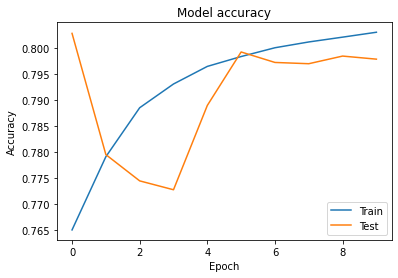

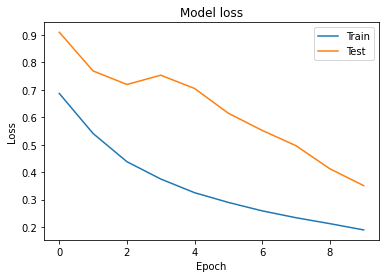

In [104]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc= 'lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['ssim_loss'])
plt.plot(history.history['val_ssim_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [105]:
s = history.history['val_ssim_loss']

In [106]:
import pickle
import matplotlib.pyplot as plt

name = '64_training_curve.dat'

try:
  with open(name,'rb') as f:
    training_records = pickle.load(f)

except:
  with open(name,'wb') as f:
    training_records = []
    pickle.dump(training_records,f)
    print('First created file:{}'.format(name))

In [107]:
training_records.append(s)

with open(name,'wb') as f:
  pickle.dump(training_records,f)


In [108]:
print("running time: {:0.1f}s".format(end - start))

running time: 446.8s


In [109]:
# cd /content/drive/My Drive/Colab Notebooks/MMF data/24hours_Mix_datasets/24hours_img_v2

0: dense \\
1: U-net / not trained  \\
2: U-net a = 2 add sigmoid / not trained \\
3: U-net a = 1 not trained \\
4: U-net去掉bug 730.5s \\
5: U-net 256 between \\
6: u-net relu 倒数第二层。 \\
8: 调整过后。 \\
11： U-net三层 conv \\
12: U-net 调整  251.6s \\
23: Fashion Mnist \\
28: U-net standard a= 1 \\
29: a = 0.5 \\
30: a = 1.2 \\
31: a = 1.1  \\
32: a = 0.9 \\
33: 回到fashion mnist \\


**************************
34: U-net baseline a= 1 , dropout = 0.2 \\
35： a = 0.5 \\
36: a = 2 \\
37: without connection layer a =1 \\
38: without connection layer a =0.5 \\
39: delete to a autoencoder (0 conv layer, failed) \\
40: delete to a autoencoder ( 1 conv layer each) \\
42: dropout 0.1  \\
43: dropout 0.3  \\
44: dropout 0.4  \\
45: delete two layers: a= 0.5 \\
46: delete four layers: a= 0.5 \\
47: VGG baseline 784 nodes \\
48: Reverse VGG 784 nodes \\
49: Dense 1024 nodes-SSIM loss \\
50: Dense 1024 nodes-Cross entropy loss \\
51: Dense 1024 nodes-MSE loss \\

52: Reverse VGG 1024 nodes MSE loss \\
53: Reverse VGG 256 nodes MSE loss \\
54: Reverse VGG 256 nodes SSIM loss \\
55: Reverse VGG 1024 nodes SSIM loss \\
57:  dense mnist \\
58:  dense Fashmnist \\
60  U-net filter 2 and 1  \\

*********2020/08/12*******重新测试 \\
61: U-net optimization results with dropouts \\
62: U-net optimization results with dropouts/ reduce datasets \\
63: delete dropout layer \\
64: add one normalization layer \\
65: add three normalization layers \\
66: add all normalization layers \\
67: add dropout with batch normalization \\
68: add extreme batch normalization \\
69: Dense (baseline)  \\
70: Relu after batch normalization \\
71: batch normalization a=2 \\
72: batch normalization a=2, add dropout \\
73: redo Dense baseline \\
74： batch normalization a = 3  \\
75： batch normalization a = 4  \\
76： batch normalization a = 5  \\
77： dense with batch normalization \\
78: dense sigmoid after BN (with dropout) \\
79: dense sigmoid after BN (without dropout) \\
80: dense relu after BN (without dropout) \\
81：dense relu  \\
82: dense relu with dropout \\
83: dense baseline early stop = 20 Fashion mnist \\
84: U-net a = 4 Fashion mnist \\
85: dense Fashion mnist \\
86: U-net a = 4 Mnist batchsize = 512 \\
87: U-net a = 4 Mnist batchsize = 128 \\
88: U-net a = 4 Mnist batchsize = 640 \\

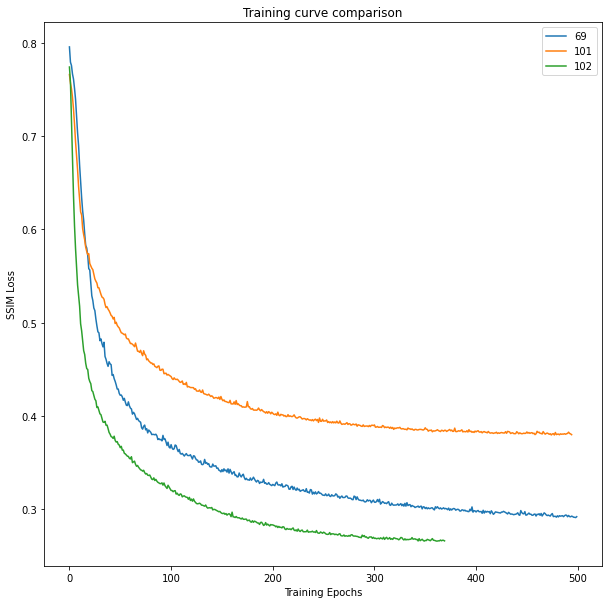

In [110]:
plt.figure(figsize = (10,10))
plt.title('Training curve comparison')
plt.xlabel('Training Epochs')
plt.ylabel('SSIM Loss')
#plt.xlim(0,200)

specify_mode = 1   # 0 for normal mode, 1 for plot_list
plot_list = [69, 101,102]


if specify_mode == 0:
  for i in range(86, len(training_records)):
    plt.plot(training_records[i],label = i)

if specify_mode == 1:
  for i in plot_list:
    plt.plot(training_records[i],label = i)

plt.legend()


Result analysis

In [111]:
from tensorflow.keras.models import load_model

Detective = load_model('/content/drive/My Drive/Colab Notebooks/MMF data/Mnist image data/my_model.h5')

autoencoder.load_weights('best_model.h5')

decoded_imgs = autoencoder.predict(test_imgs)

Average SSIM

In [112]:
def MSE(A,B):
  err = np.sum((A.astype("float") - B.astype("float"))**2)
  err /= float(A.shape[0]*A.shape[1])
  return err

In [113]:
import time
from skimage.metrics import structural_similarity as ssim


Number = 500

#x_test_noisy , imgs_test = next_batch (Number , train_imgs, train_origins)
x_test_noisy , imgs_test = next_batch (Number , test_imgs, test_origins)

x_test_noisy = x_test_noisy.reshape((-1,64,64,1))
imgs_test = imgs_test.reshape((-1,28,28,1))

c_1 = time.time()
recon_img = autoencoder.predict(x_test_noisy)
c_2 = time.time()

SSIM_test = []
MSE_test = []

for i in range(Number):
  s =ssim(recon_img[i],imgs_test[i], multichannel = True)
  k = MSE(recon_img[i], imgs_test[i])
  SSIM_test.append(s)
  MSE_test.append(k)

print('reconstruction time = {:.4f}s'.format(c_2-c_1))
print('average SSIM = {:.2f}'.format(sum(SSIM_test)/Number))
print('SSIM variance = {:.4f}'.format(np.var(SSIM_test)))
print('average MSE = {:.2f}'.format(sum(MSE_test)/Number))
print('MSE variance = {:.4f}'.format(np.var(MSE_test)))

answer1 = Detective.predict(recon_img.reshape(-1,28,28))
answer2 = Detective.predict(imgs_test.reshape(-1,28,28))

count = 0

for i in range(Number):
  if np.argmax(answer1[i]) == np.argmax(answer2[i]):
    count += 1
  else:
    pass
print('The classification network sucessfully distinguished {} images out of 1000 images'.format(2*count))
print('Classification accuracy: {}'.format(2*count/1000.0))
    

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


reconstruction time = 2.5753s
average SSIM = 0.70
SSIM variance = 0.0167
average MSE = 0.04
MSE variance = 0.0003
The classification network sucessfully distinguished 802 images out of 1000 images
Classification accuracy: 0.802


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'SSIM value'),
 Text(0.5, 1.0, 'Frequency Histogram for U-net')]

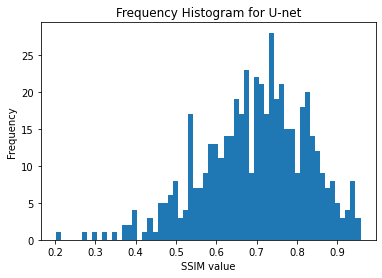

In [114]:
plt.figure()
plt.hist(SSIM_test,bins = 60)
plt.gca().set(title='Frequency Histogram for U-net', xlabel = 'SSIM value', ylabel='Frequency')

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'MSE value'),
 Text(0.5, 1.0, 'Frequency Histogram for SHL-DNN')]

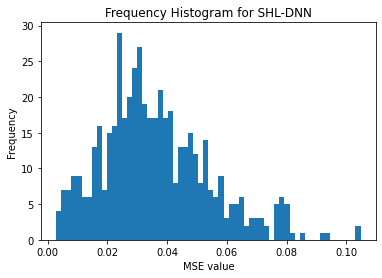

In [115]:
plt.figure()
plt.hist(MSE_test,bins = 60)
plt.gca().set(title='Frequency Histogram for SHL-DNN', xlabel = 'MSE value', ylabel='Frequency')

查看图像效果

In [116]:
#plot the results of predicted test images with respect to origins
from random import shuffle
def plot_results(test_images, test_origins):
    images = autoencoder.predict(test_images)
    k = np.arange(len(images))
    shuffle(k)
    print('Reconstructed images')
    for i in range(0 , 5):
      plt.subplot(1,5,i+1)
      plt.imshow(images[k[i]].reshape(28,28), cmap = 'gray')
      #answer = Detective.predict(images[k[i]].reshape(1,28,28))
      #plt.title(np.argmax(answer))
      #s = ssim(images[k[i]].reshape(28,28),test_origins[k[i]].reshape(28,28),multichannel = True)
      #plt.xlabel('SSIM = {:.2f}'.format(s))
    plt.show()
    
    print('Ground truth')
    for i in range(0,5):
      plt.subplot(1,5,i+1)
      #answer = Detective.predict(test_origins[k[i]].reshape(1,28,28))
      #plt.title(np.argmax(answer))
      plt.imshow(test_origins[k[i]].reshape(28,28), cmap = 'gray')
    plt.show()


Reconstructed images


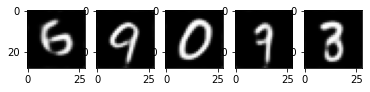

Ground truth


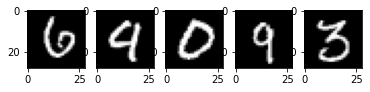

In [117]:
plot_results(test_imgs,test_origins)

In [118]:
images = autoencoder.predict(test_imgs)
k = np.arange(len(images))

In [119]:
np.shape(test_imgs)

(3238, 64, 64, 1)

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


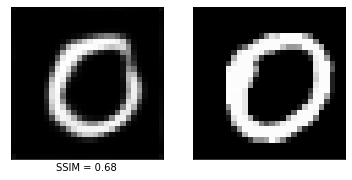

In [120]:
shuffle(k)
i= 0

fig = plt.figure()

plt.subplot(1,2,1)

plt.xticks([])
plt.yticks([])

plt.imshow(images[k[i]].reshape(28,28), cmap = 'gray')
s = ssim(images[k[i]].reshape(28,28),test_origins[k[i]].reshape(28,28),multichannel = True)
plt.xlabel('SSIM = {:.2f}'.format(s))

plt.subplot(1,2,2)

plt.xticks([])
plt.yticks([])
plt.imshow(test_origins[k[i]].reshape(28,28), cmap = 'gray')
plt.show()

In [121]:
print(k[i])

2887


In [122]:
# with open('img_to_test.dat','wb') as f:
#   pickle.dump(img_to_test, f)

# with open('origin_to_test.dat','wb') as f:
#   pickle.dump(origin_to_test, f)

In [123]:
with open('img_to_test.dat','rb') as f:
  img_to_test = pickle.load(f)

with open('origin_to_test.dat','rb') as f:
  origin_to_test = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
predict_imgs = autoencoder.predict(img_to_test)

n= 2111,1811,1567,2305,210,311

In [ ]:
n = 311

fig2 = plt.figure()

plt.xticks([])
plt.yticks([])
plt.imshow(img_to_test[n].reshape(64,64), cmap = 'gray')
plt.show()



In [ ]:
fig2.savefig('Output_6.svg')

In [ ]:
# For generating desired images

fig = plt.figure()

plt.subplot(1,3,1)

plt.xticks([])
plt.yticks([])

plt.imshow(predict_imgs[n].reshape(28,28), cmap = 'gray')
s = ssim(predict_imgs[n].reshape(28,28),origin_to_test[n].reshape(28,28),multichannel = True)
plt.xlabel('SSIM = {:.2f}'.format(s))

plt.subplot(1,3,2)

plt.xticks([])
plt.yticks([])
plt.imshow(origin_to_test[n].reshape(28,28), cmap = 'gray')
plt.show()

plt.subplot(1,3,3)

plt.xticks([])
plt.yticks([])
plt.imshow(img_to_test[n].reshape(64,64), cmap = 'gray')
plt.show()

In [ ]:
# fig.savefig('input_2.svg')

In [ ]:
# get the data within the specific hours
def get_test_data(N_start, N_end):  #N_start refer to the hours, eg: N_start = 3

  Final_test = []
  Final_origin = []

  for i in range(N[N_start], N[N_end]):
    if i % 2 == 1:           # 0 for Fashion Mnist and 1 for Mnist.
      Final_test.append(imgs_all[i].reshape(64,64,1))
      Final_origin.append(origins_all[i].reshape(28,28,1))

  Final_test = np.array(Final_test).astype(float)   
  Final_origin = np.array(Final_origin).astype(float)

  return Final_test/255.0, Final_origin/255.0

In [ ]:
x, y = get_test_data(0,6)
plot_results(x,y)